# 1. Install and Import Dependencies

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [ ]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [ ]:
!pip install mss pydirectinput pytesseract

In [ ]:
!pip install gym pyautogui

In [29]:
from mss import mss
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete
import pyautogui

# 2. Build the Environment

## 2.1 Create Environment

In [47]:
import csv
import os
import math

def record_scores(high_score, min_score, avg_score,reward, file_name='score.csv'):
    # Check if the file already exists
    file_exists = os.path.isfile(file_name)

    # Open the file in append mode
    with open(file_name, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # If the file doesn't exist, write the header
        if not file_exists:
            writer.writerow(['High Score', 'Min Score', 'Avg Score','reward'])
        
        # Write the score data
        writer.writerow([high_score, min_score, avg_score,reward])

# Example usage



In [59]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(4)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 250, 'left': 100, 'width': 550, 'height': 450}
        self.done_location = {'top': 540, 'left': 300, 'width': 150, 'height': 100}
        self.score_location = {'top': 200, 'left': 160, 'width': 40, 'height': 50}
        self.score = 0
        self.epoch = 0
        self.highscore = 0
        self.minscore = 100000
        self.total_score=0
        self.reward = 0
        self.total_reward = 0

        self.isVertical = False
        
    def step(self, action):
        if action != 2:
            if self.isVertical:
                self.isVertical = False
                if action == 0:
                    pyautogui.press('left')
                else:
                    pyautogui.press('right')
            else:
                self.isVertical = True
                if action == 0:
                    pyautogui.press('up')
                else:
                    pyautogui.press('down')

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        _,_,score = self.get_score()
        self.reward = 1
        self.reward += (max(score - self.score,0)*10)
        self.total_reward += self.reward
        self.score = score
        info = {}
        return observation, self.reward, done, info
        
    
    def reset(self):
        self.isVertical = False
        self.epoch += 1
        self.total_score += self.score
        self.highscore = max(self.highscore, self.score)
        self.minscore = min(self.minscore, self.score)
        if self.epoch%50==0:
            record_scores(self.highscore, self.minscore, math.ceil(self.total_score/50),math.ceil(self.total_reward/50))
            self.highscore = 0
            self.minscore = 100000
            self.total_score= 0
            self.total_reward = 0

        time.sleep(1)
        self.score = 0
        pyautogui.click(x=500,y=500)
        pyautogui.press('space')
        pyautogui.press('right')

        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_score(self):
        cap = np.array(self.cap.grab(self.score_location))
        res = pytesseract.image_to_string(cap, config='--psm 10')
        try:
            score = int(res)
        except:
            score = self.score
        return cap, res, score


    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = 'lay'
        done=False
        res = pytesseract.image_to_string(done_cap)
        if done_strings in res:
            done = True
        return done, done_cap

# 2.2 Test Environment

In [48]:
env = WebGame()

In [49]:
cap, res, score=env.get_score()
res, score

('0\n', 0)

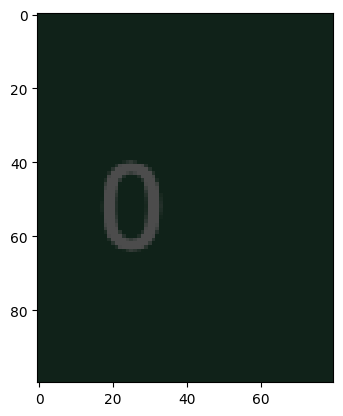

In [8]:
plt.imshow(cap)

In [9]:
obs=env.get_observation()

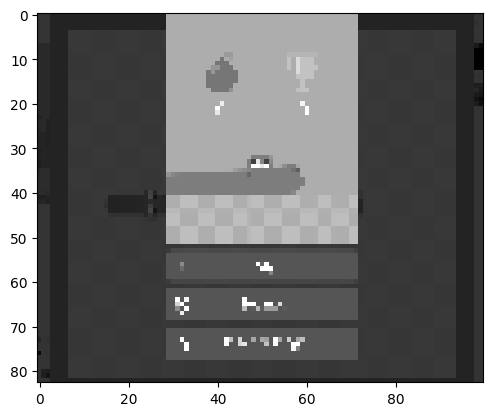

In [10]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2RGB))

In [11]:
done, done_cap = env.get_done()

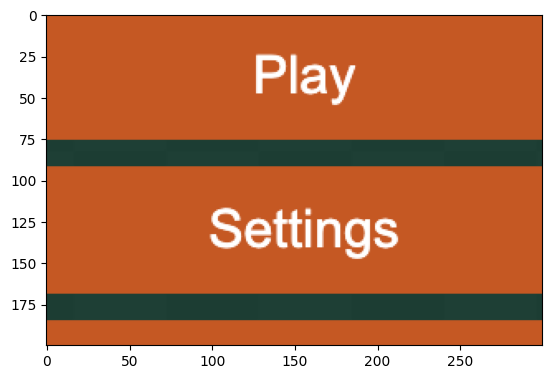

In [12]:
plt.imshow(done_cap)

In [13]:
pytesseract.image_to_string(done_cap)

'Play\n——\nSettings\na\n'

In [14]:
done

True

In [36]:
time.sleep(2)
i = 0
for k in range(10):
    i+=1
    obs = env.reset()
    done = False  
    total_reward = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(i, total_reward))    

Total Reward for episode 1 is 6
Total Reward for episode 2 is 6
Total Reward for episode 3 is 11
Total Reward for episode 4 is 7
Total Reward for episode 5 is 17
Total Reward for episode 6 is 13
Total Reward for episode 7 is 7
Total Reward for episode 8 is 13
Total Reward for episode 9 is 9
Total Reward for episode 10 is 11


# 3. Train the Model

## 3.1 Create Callback

In [ ]:
!pip uninstall numpy -y


In [ ]:
%pip install numpy==1.23

In [244]:
import numpy as np
np.version.version

'1.23.0'

In [60]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [61]:
env_checker.check_env(env)

AssertionError: Your environment must inherit from the gymnasium.Env class cf. https://gymnasium.farama.org/api/env/

In [62]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [63]:
CHECKPOINT_DIR = './train-snake/'
LOG_DIR = './logs-snake/'

In [64]:
callback = TrainAndLoggingCallback(check_freq=5000, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [65]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [76]:
env = WebGame()

In [67]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=8000000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/patkamon/.pyenv/versions/3.10.13/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/patkamon/.pyenv/versions/3.10.13/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 132.93GB > 8.85GB
  warnings.warn(


In [83]:
model = DQN.load('train-snake/best_model_80000', env=env, tensorboard_log=LOG_DIR)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/patkamon/.pyenv/versions/3.10.13/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/patkamon/.pyenv/versions/3.10.13/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 132.93GB > 7.57GB
  warnings.warn(


In [78]:
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/patkamon/.pyenv/versions/3.10.13/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
model.set_parameters('train-snake/best_model_80000')

In [75]:
model.load_replay_buffer('logs-snake/events.out.tfevents.1728401191.patkamons-MacBook-Pro.local.7339.5')

FileNotFoundError: [Errno 2] No such file or directory: 'logs-snake/events.out.tfevents.1728401191.patkamons-MacBook-Pro.local.7339.5.pkl'

In [82]:
model.learn(total_timesteps=100000, callback=callback) 

Logging to ./logs-snake/DQN_16
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 12.5     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 28       |
|    total_timesteps  | 40       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.75     |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 54       |
|    total_timesteps  | 78       |
----------------------------------


KeyboardInterrupt: 

In [69]:
model.load('train-snake/best_model_80000') 

/Users/patkamon/.pyenv/versions/3.10.13/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 132.93GB > 7.78GB
  warnings.warn(


# 4. Test out Model

In [168]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

KeyboardInterrupt: 